## This is a notebook for Table X - LSTM Performance with Different Parameters

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Get the directory of the current script
try:
    # This will work if the script is being run as a file
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Use the current working directory if __file__ is not defined
    current_dir = os.getcwd()
# Move up one directory level from EDA to the parent directory
parent_dir = os.path.dirname(current_dir)
# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'xdrive')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)

featureeng_path = os.path.join(parent_dir, 'Feature Engineering')
# Add the xdrive path to sys.path
sys.path.append(featureeng_path)

# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'Pipeline')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)
from build_a_pipeline import build_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense
from build_a_pipeline import build_pipeline_P0_foward_price
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense
from sklearn.metrics import r2_score
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


## MODEL 3
- Multiple multivariate layers

## P0 Prediction

In [2]:
model_performance = []
x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(drop_features=True, 
                                                                                remove_outliers = True, 
                                                                                percentage_of_outliers=0.01) #drop_features = False
datetime_index = X_test.index
feature_names_P0 = X_test.columns
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
X_test = X_test.to_numpy()

# merge train and validation
x_train_combined = np.vstack([x_train, x_val])  # Combine x_train and x_val
y_train_combined = np.concatenate([y_train, y_val])  # Combine y_train and y_val
y_train = y_train_combined

#reshape
x_train = x_train_combined.reshape(x_train_combined.shape[0], 1, x_train_combined.shape[1])  # [samples, time_steps=1, features]
# Test data
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) 

  

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(200, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(100, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(50, activation='selu')), 
    Dropout(0.3),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_test, y_test),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final test RMSE: {val_rmse}")

from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_test)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")
model_performance.append({
    'Model': 'Model 3' ,
    'Target': 'P0',
    'Train RMSE': train_rmse,
    'Test RMSE': val_rmse,
    'R2': r_squared
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 18609.7793 - root_mean_squared_error: 135.8916 - val_loss: 16870.9570 - val_root_mean_squared_error: 129.8882
Epoch 2/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3527.5564 - root_mean_squared_error: 58.9535 - val_loss: 17328.8672 - val_root_mean_squared_error: 131.6391
Epoch 3/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1643.3663 - root_mean_squared_error: 40.4823 - val_loss: 15442.1025 - val_root_mean_squared_error: 124.2663
Epoch 4/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1106.1019 - root_mean_squared_error: 33.2305 - val_loss: 13141.3242 - val_root_mean_squared_error: 114.6356
Epoch 5/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1451.0623 - root_mean_squared_error: 38.0150 - val_loss: 13627.4961 - val_root_mean_squared_error: 116.7369
Epoch 6/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1033.7446 - root_mean_squared_error: 31.8064 - val_loss: 15620.7568 - val_root_mean_squared_error: 124.9830
Epoch 7

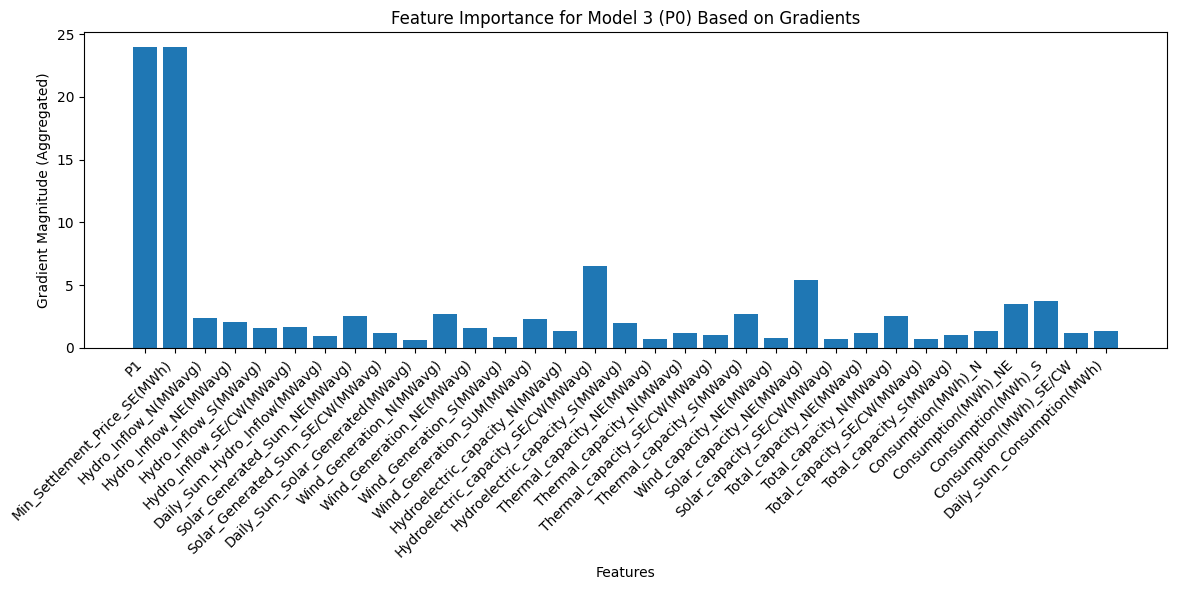

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to compute gradients
def compute_gradients(input_data, model, target_index=0):
    input_tensor = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        target = predictions[:, target_index]  # Target the specific output
    gradients = tape.gradient(target, input_tensor)
    return gradients.numpy()

# Compute gradients for your test data
grads = compute_gradients(x_test, multivariate_lstm)


# Assuming `feature_names` is a list of column names corresponding to your features
# Example: feature_names = ["Feature1", "Feature2", ..., "FeatureN"]
feature_importance = np.sum(np.abs(grads), axis=1).mean(axis=0)  # Shape: (features,)

# Bar plot for feature importance with feature names
plt.figure(figsize=(12, 6))
plt.bar(feature_names_P0, feature_importance)
plt.xlabel('Features')
plt.ylabel('Gradient Magnitude (Aggregated)')
plt.title('Feature Importance for Model 3 (P0) Based on Gradients')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

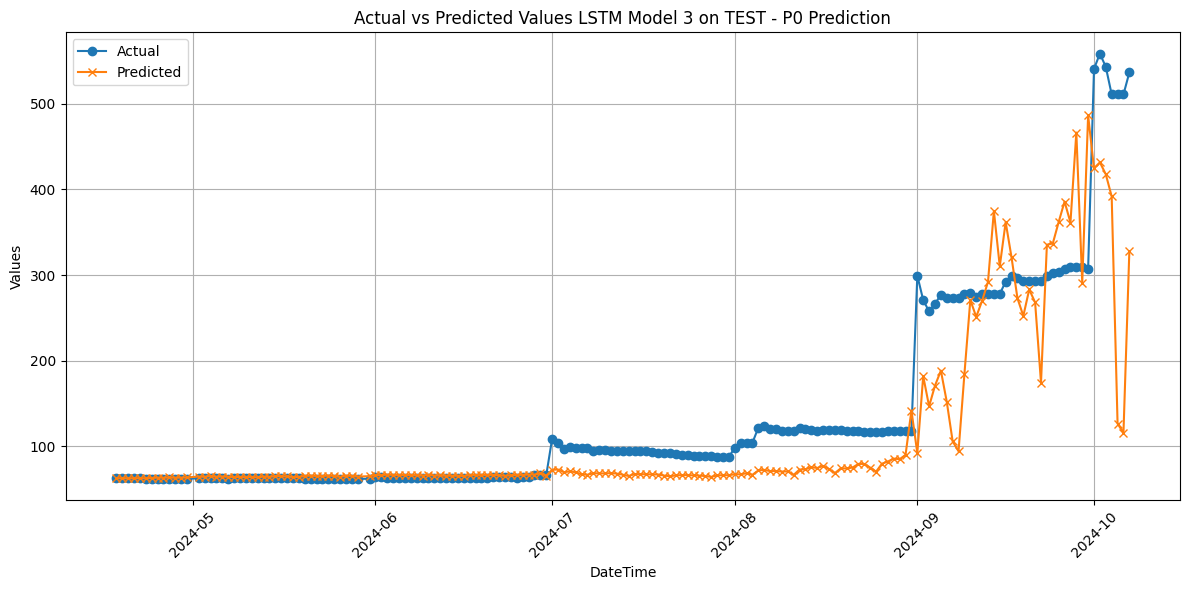

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index, columns=['Predicted'])
y_test_df = pd.DataFrame(y_test, index=datetime_index, columns=['Actual'])
predictions_df = predictions_df.sort_index()
y_test_df = y_test_df.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(datetime_index, y_test, label='Actual', marker='o')
plt.plot(y_test_df.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values LSTM Model 3 on TEST - P0 Prediction')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### P1 Prediction

In [6]:

x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(drop_features=True, 
                                                                                remove_outliers = True, 
                                                                                target_column = 'P1',
                                                                                percentage_of_outliers=0.01) #drop_features = False

datetime_index = X_test.index
feature_names_P1 = X_test.columns
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
X_test = X_test.to_numpy()

# merge train and validation
x_train_combined = np.vstack([x_train, x_val])  # Combine x_train and x_val
y_train_combined = np.concatenate([y_train, y_val])  # Combine y_train and y_val
y_train = y_train_combined

#reshape
x_train = x_train_combined.reshape(x_train_combined.shape[0], 1, x_train_combined.shape[1])  # [samples, time_steps=1, features]
# Test data
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) 

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(250, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(200, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(100, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(50, activation='selu')), 
    Dropout(0.3),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)
#optimizer = Adam(learning_rate=1e-2, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_test, y_test),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")


from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_test)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")
model_performance.append({
    'Model': 'Model 3' ,
    'Target': 'P1',
    'Train RMSE': train_rmse,
    'Test RMSE': val_rmse,
    'R2': r_squared
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 27581.0566 - root_mean_squared_error: 164.0188 - val_loss: 35153.1992 - val_root_mean_squared_error: 187.4919
Epoch 2/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4910.7764 - root_mean_squared_error: 69.2117 - val_loss: 27611.5117 - val_root_mean_squared_error: 166.1671
Epoch 3/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1966.3597 - root_mean_squared_error: 44.0709 - val_loss: 23718.6113 - val_root_mean_squared_error: 154.0085
Epoch 4/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2066.0244 - root_mean_squared_error: 45.3610 - val_loss: 24693.7480 - val_root_mean_squared_error: 157.1424
Epoch 5/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2134.1636 - root_mean_squared_error: 45.8228 - val_loss: 23164.9199 - val_root_mean_squared_error: 152.2003
Epoch 6/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2834.8237 - root_mean_squared_error: 52.6853 - val_loss: 24210.3105 - val_root_mean_squared_error: 155.5966
Epoch 7

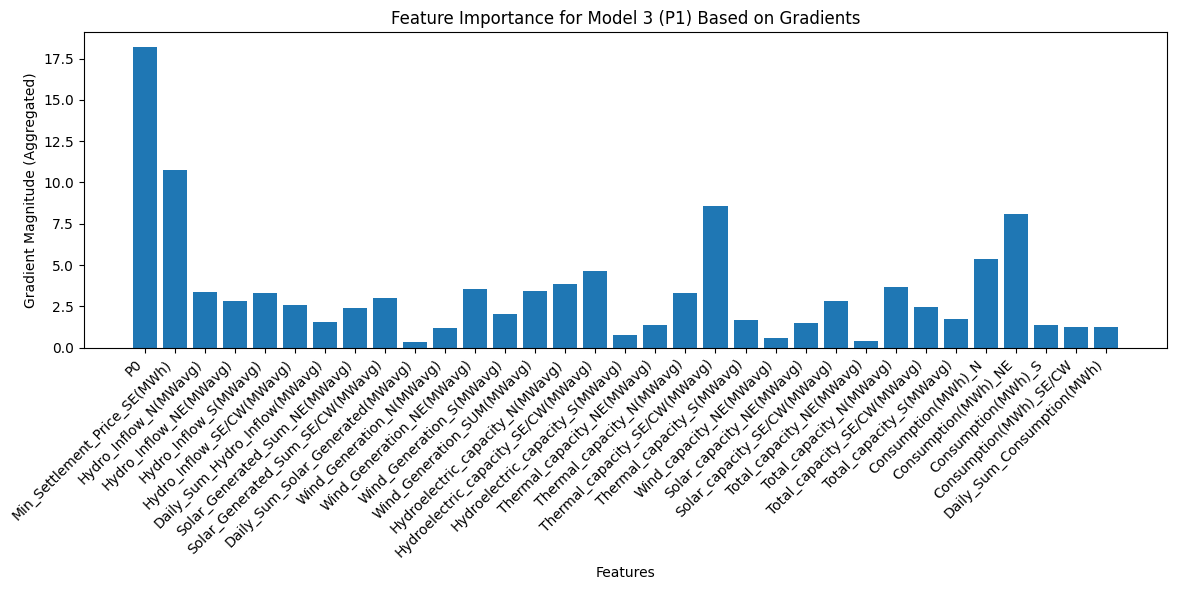

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to compute gradients
def compute_gradients(input_data, model, target_index=0):
    input_tensor = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        target = predictions[:, target_index]  # Target the specific output
    gradients = tape.gradient(target, input_tensor)
    return gradients.numpy()

# Compute gradients for your test data
grads = compute_gradients(x_test, multivariate_lstm)


# Assuming `feature_names` is a list of column names corresponding to your features
# Example: feature_names = ["Feature1", "Feature2", ..., "FeatureN"]
feature_importance = np.sum(np.abs(grads), axis=1).mean(axis=0)  # Shape: (features,)

# Bar plot for feature importance with feature names
plt.figure(figsize=(12, 6))
plt.bar(feature_names_P1, feature_importance)
plt.xlabel('Features')
plt.ylabel('Gradient Magnitude (Aggregated)')
plt.title('Feature Importance for Model 3 (P1) Based on Gradients')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

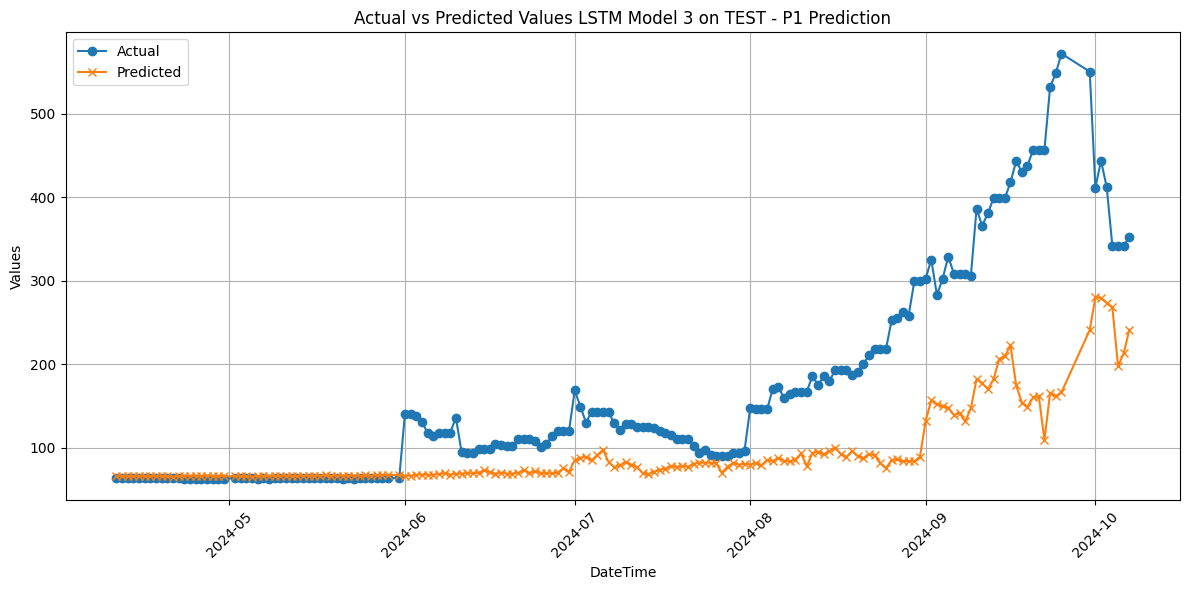

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index, columns=['Predicted'])
y_test_df = pd.DataFrame(y_test, index=datetime_index, columns=['Actual'])
predictions_df = predictions_df.sort_index()
y_test_df = y_test_df.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(datetime_index, y_test, label='Actual', marker='o')
plt.plot(y_test_df.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values LSTM Model 3 on TEST - P1 Prediction')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
df = pd.DataFrame(model_performance)
df

,Model,Target,Train RMSE,Test RMSE,R2
0,Model 3,P0,23.371555,91.395889,0.663716
1,Model 3,P1,29.754862,160.410736,0.164985
